In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***`Libraries`***

In [2]:
!pip install --upgrade mlxtend
!pip install kmodes
!pip install gower
!pip install scikit-learn
!pip install --upgrade jax jaxlib
!pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as sch
import gower
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

In [4]:
  import warnings
  warnings.filterwarnings("ignore")

# ***`EDA`***

In [6]:
df_cleaned = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_cleaned.xlsx')
df_cleaned.head(2)

Name_Shop   revenue  positive  negative  total_feedback  \
0               2N Unisex   1326000       233        46             279   
1  3M Automotive Official  25545495       312       104             416   

   Year_Joined  Shop_Rating  Counter_Rating  Followers  Chat Resopnse  
0            5          4.7            1100        982              0  
1            4          4.7            1400       1500              0

In [7]:
null_values = df_cleaned.isnull().sum()
print(null_values)

Name_Shop         0
revenue           0
positive          0
negative          0
total_feedback    0
Year_Joined       0
Shop_Rating       0
Counter_Rating    0
Followers         0
Chat Resopnse     0
dtype: int64


In [8]:
df_cleaned['Chat Resopnse'] = df_cleaned['Chat Resopnse'] / 100
df_cleaned = df_cleaned.drop(columns=['Name_Shop'])
df_cleaned['Year_Joined'] = df_cleaned['Year_Joined'].replace(0, 1)
df_cleaned = df_cleaned[df_cleaned['Counter_Rating'] != 0]

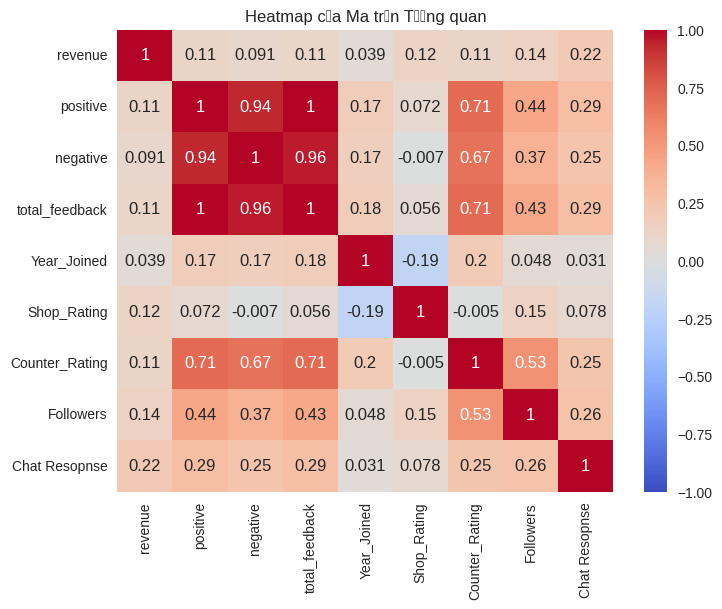

In [9]:
# Tính toán ma trận tương quan
correlation_matrix = df_cleaned.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

# ***`Wilson score interval`***

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Giả sử bạn có DataFrame df với các cột Shop_Rating và Counter_Rating
# Xác định z cho mức độ tin cậy mong muốn (95% confidence level)
z = norm.ppf(0.975)  # z = 1.96 cho mức độ tin cậy 95%

# Hàm tính điểm Wilson
def wilson_score(average_rating, total_ratings, z=z):
    p_hat = average_rating / 5  # Chuyển đổi Shop_Rating thành tỷ lệ giữa 0 và 1
    denominator = 1 + z**2 / total_ratings
    center_adjusted_probability = p_hat + z**2 / (2 * total_ratings)
    adjusted_standard_deviation = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total_ratings)) / total_ratings)
    wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
    return wilson_lower_bound * 5  # Quy đổi về thang 5 sao

# Áp dụng hàm vào cột mới 'Wilson_Score' trong DataFrame
# Thay đổi ở đây: Truyền các giá trị của từng hàng vào hàm wilson_score
df_cleaned['Rating_quality'] = df_cleaned.apply(lambda x: wilson_score(x['Shop_Rating'], x['Counter_Rating']), axis=1)

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Giả sử bạn có DataFrame df với các cột positive, negative, total_feedback
# Xác định z cho mức độ tin cậy mong muốn (95% confidence level)
z = norm.ppf(0.975)  # z = 1.96 cho mức độ tin cậy 95%

# Hàm tính điểm Wilson
def wilson_score(positive, total_feedback, z=z):
    if total_feedback == 0:
        return 0  # Trả về 0 nếu không có feedback nào
    p_hat = positive / total_feedback  # Tỷ lệ tích cực
    denominator = 1 + z**2 / total_feedback
    center_adjusted_probability = p_hat + z**2 / (2 * total_feedback)
    adjusted_standard_deviation = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total_feedback)) / total_feedback)
    wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
    return wilson_lower_bound

# Áp dụng hàm vào cột mới 'Wilson_Score_Positive' trong DataFrame
df_cleaned['Positive_quality'] = df_cleaned.apply(lambda x: wilson_score(x['positive'], x['total_feedback']), axis=1)
# df_cleaned['Negative_quality'] = df_cleaned.apply(lambda x: wilson_score(x['negative'], x['total_feedback']), axis=1)

In [12]:
df_cleaned = df_cleaned.drop(columns=['positive', 'negative', 'total_feedback', 'Shop_Rating', 'Counter_Rating'])

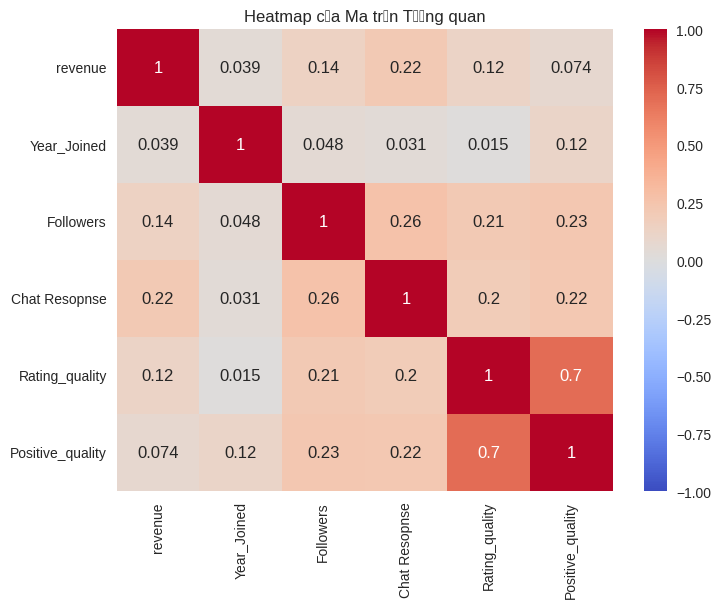

In [13]:
# Tính toán ma trận tương quan
correlation_matrix = df_cleaned.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

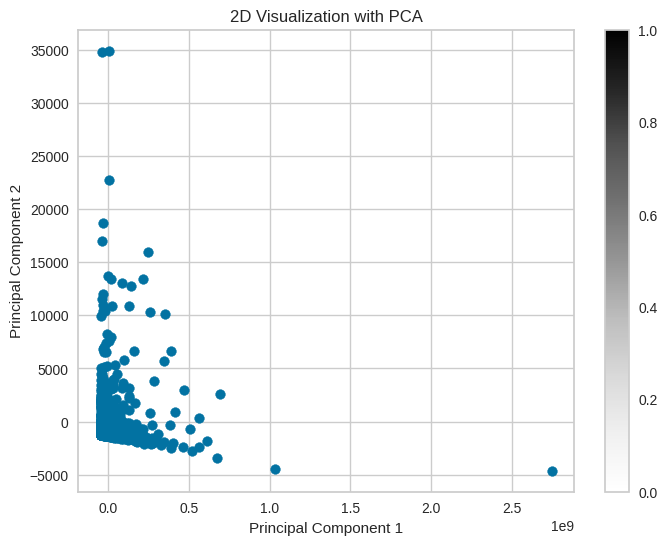

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giả sử bạn có dữ liệu nhiều chiều trong X
# Sử dụng PCA để giảm xuống còn 2 thành phần
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cleaned)

# Trực quan hóa dữ liệu
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')  # Thay labels bằng nhãn cụm nếu có
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization with PCA')
plt.colorbar()
plt.show()


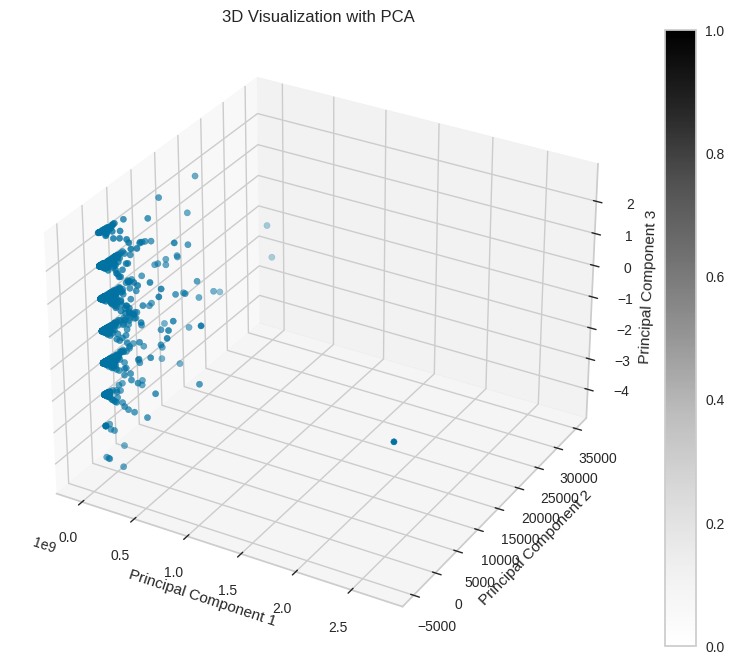

In [15]:
# Giả sử bạn có dữ liệu nhiều chiều trong X
# Sử dụng PCA để giảm xuống còn 3 thành phần
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_cleaned)

# Trực quan hóa dữ liệu trong không gian 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], cmap='viridis')  # Replace 'labels' with your data labels or clustering results
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D Visualization with PCA')
plt.colorbar(sc)
plt.show()

# ***`Describe`***

In [16]:
df_copy_temp =  df_cleaned.copy()
df_copy_temp.describe()

revenue  Year_Joined     Followers  Chat Resopnse  Rating_quality  \
count  9.330000e+02   933.000000    933.000000     933.000000      933.000000   
mean   4.443773e+07     5.403001   1407.422294       0.349400        4.390583   
std    1.319756e+08     1.442931   2965.526020       0.426577        0.447215   
min    0.000000e+00     1.000000      1.000000       0.000000        0.472656   
25%    1.712999e+06     4.000000    140.000000       0.000000        4.296420   
50%    7.390000e+06     6.000000    479.000000       0.000000        4.493360   
75%    2.980900e+07     7.000000   1395.000000       0.830000        4.638440   
max    2.792880e+09     8.000000  36317.000000       1.000000        4.963264   

       Positive_quality  
count        933.000000  
mean           0.678008  
std            0.149187  
min            0.000000  
25%            0.641034  
50%            0.715368  
75%            0.771763  
max            0.927649

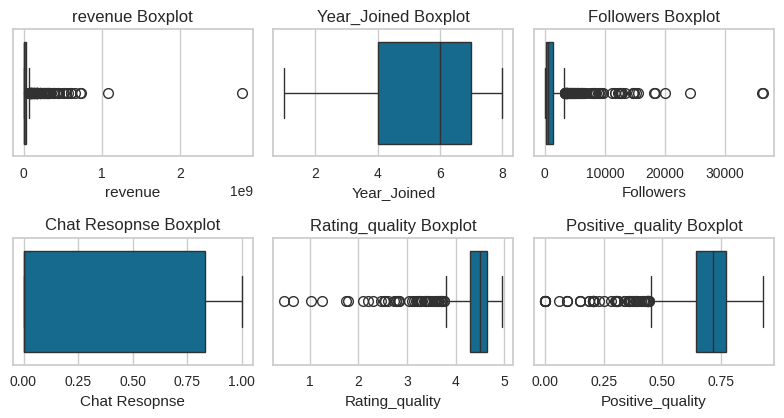

In [17]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(df_copy_temp.describe().columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=df_copy_temp[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

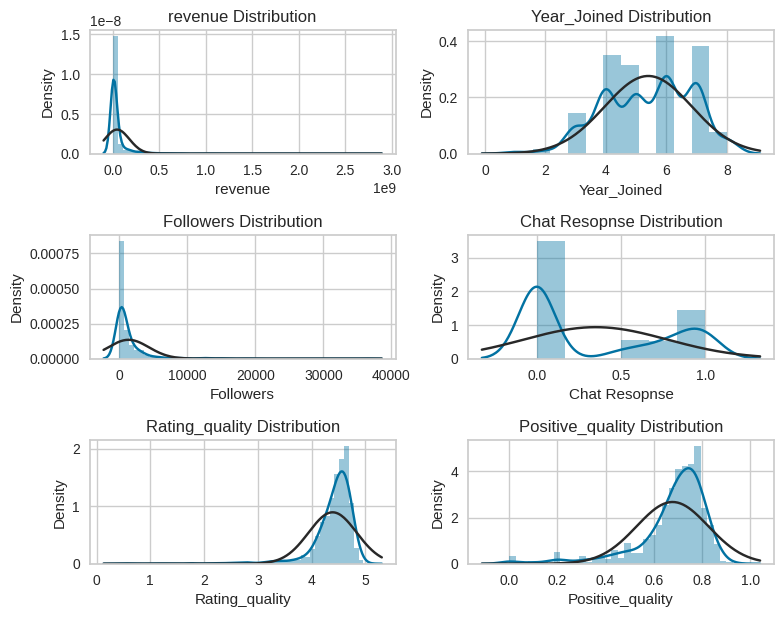

In [18]:
import scipy.stats as stats

# Visualize the distribution of each variable.
plt.figure(figsize=(8, 10))
for i, j in enumerate(df_copy_temp.describe().columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df_copy_temp[j], fit = stats.norm)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()

# ***`Z-Score`***

In [19]:
# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa dữ liệu
scaled_data = scaler.fit_transform(df_copy_temp)
scaled_df = pd.DataFrame(scaled_data, columns=df_copy_temp.columns)

In [20]:
scaled_df

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0   -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1   -0.143226    -0.972848   0.031235      -0.819518        0.539159   
2   -0.260906     0.413962   3.475303       1.525984        0.663007   
3   -0.313024     1.107368  -0.313240      -0.819518       -0.090066   
4   -0.287069     0.413962  -0.284224       1.525984        0.379822   
..        ...          ...        ...            ...             ...   
928  0.292289    -0.972848  -0.408721       1.525984       -0.349262   
929  0.176205    -0.279443   0.581516       1.314889        0.410154   
930 -0.203387    -1.666254  -0.183682       1.361799        0.353820   
931  0.701569    -1.666254   1.329508      -0.819518        0.160550   
932 -0.256463    -1.666254   0.032584      -0.819518       -0.544182   

     Positive_quality  
0            0.731572  
1            0.189270  
2            1.122368  
3            0.500853  
4            0.768611  
..                ...  
928         -0.545265  
929          0.269981  
930          0.214836  
931          0.487386  
932         -0.921882  

[933 rows x 6 columns]

# ***`Winsorization `***

In [21]:
columns_to_winsorize = ['revenue', 'Followers', 'Rating_quality', 'Positive_quality']

for col in columns_to_winsorize:
    scaled_df[col] = winsorize(scaled_df[col], limits=[0.05, 0.05])

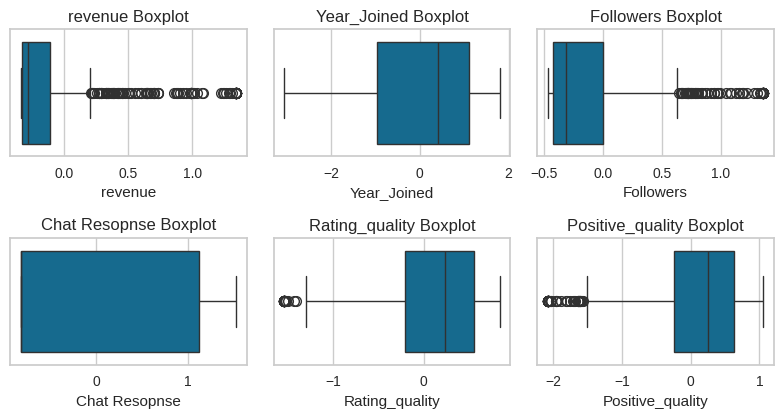

In [22]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(scaled_df.columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=scaled_df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

# ***`Isolation Forest`***

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest # Import IsolationForest from sklearn.ensemble

# Áp dụng Isolation Forest với contamination=0.1
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_pred = iso_forest.fit_predict(scaled_df)

# Lọc ra các điểm không phải outlier
inliers_df = scaled_df[outlier_pred == 1]

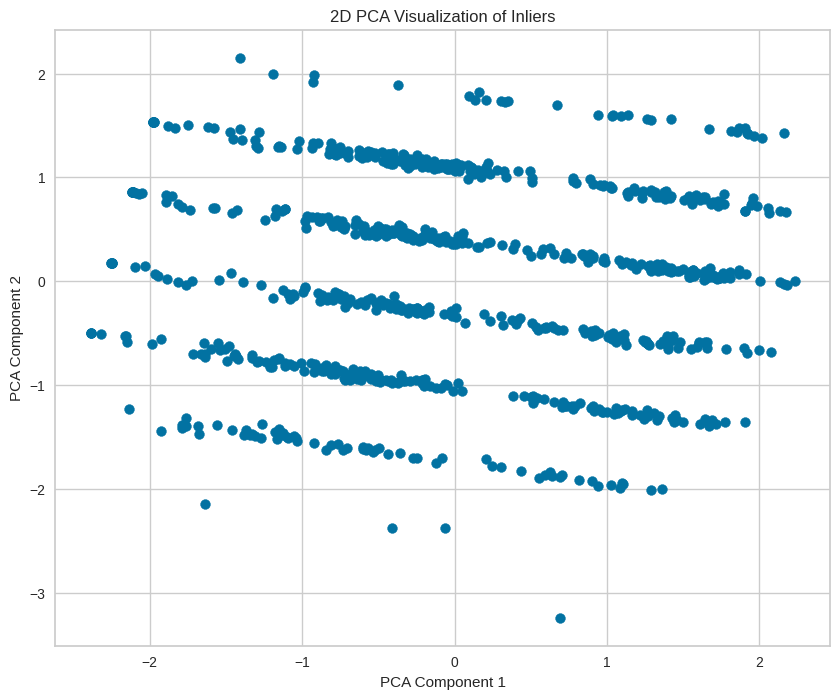

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Áp dụng PCA để giảm số chiều xuống 2
pca = PCA(n_components=2)
inliers_pca_2d = pca.fit_transform(inliers_df)

# Vẽ biểu đồ phân tán 2D
plt.figure(figsize=(10, 8))
plt.scatter(inliers_pca_2d[:, 0], inliers_pca_2d[:, 1], c='b', marker='o', s=50)

# Gán nhãn cho các trục
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Inliers')

plt.show()


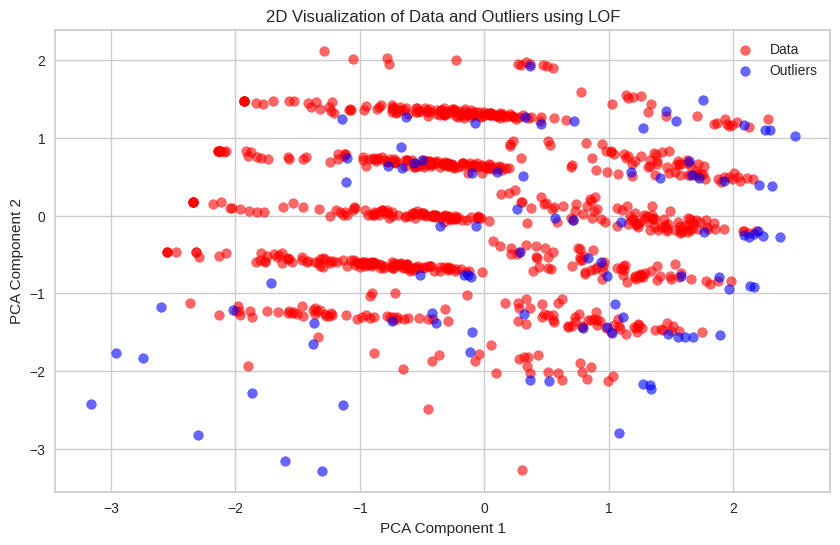

In [25]:
# Sử dụng PCA để giảm xuống 2 chiều để hiển thị
pca_2d = PCA(n_components=2, random_state=42)
df_pca_2d = pca_2d.fit_transform(scaled_df)

# Phân loại dữ liệu và outliers cho 2D (sử dụng LOF như yêu cầu cuối cùng)
df_pca_2d_data_lof = df_pca_2d[outlier_pred == 1]    # Các điểm bình thường
df_pca_2d_outliers_lof = df_pca_2d[outlier_pred == -1]  # Các outliers

# Visualize dữ liệu trong không gian 2D với LOF
plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d_data_lof[:, 0], df_pca_2d_data_lof[:, 1], color='red', label="Data", alpha=0.6)
plt.scatter(df_pca_2d_outliers_lof[:, 0], df_pca_2d_outliers_lof[:, 1], color='blue', label="Outliers", alpha=0.6)
plt.title("2D Visualization of Data and Outliers using LOF")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


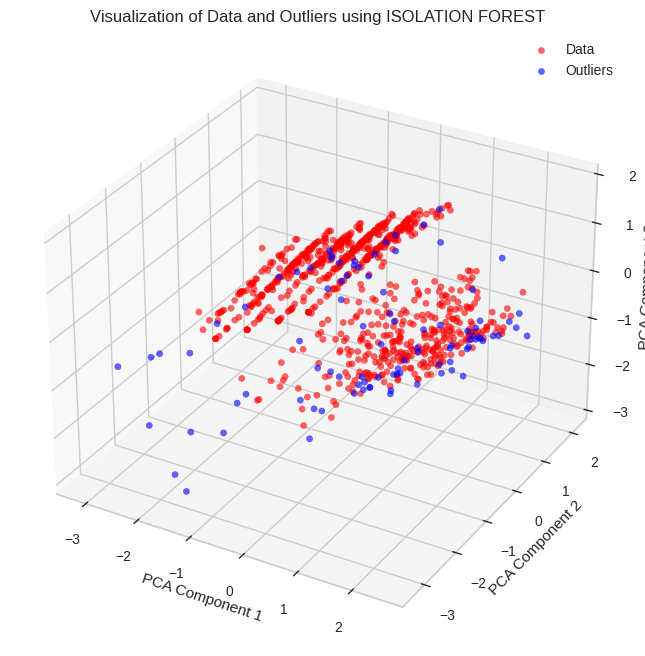

In [26]:
# Sử dụng PCA để giảm xuống 3 chiều để hiển thị
pca_3d = PCA(n_components=3, random_state=42)
df_pca_3d = pca_3d.fit_transform(scaled_df)

# Phân loại dữ liệu và outliers cho 3D (sử dụng LOF như yêu cầu cuối cùng)
df_pca_3d_data_lof = df_pca_3d[outlier_pred == 1]    # Các điểm bình thường
df_pca_3d_outliers_lof = df_pca_3d[outlier_pred == -1]  # Các outliers

# Visualize dữ liệu trong không gian 3D với LOF
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca_3d_data_lof[:, 0], df_pca_3d_data_lof[:, 1], df_pca_3d_data_lof[:, 2],
           color='red', label="Data", alpha=0.6)
ax.scatter(df_pca_3d_outliers_lof[:, 0], df_pca_3d_outliers_lof[:, 1], df_pca_3d_outliers_lof[:, 2],
           color='blue', label="Outliers", alpha=0.6)
ax.set_title("Visualization of Data and Outliers using ISOLATION FOREST")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend()
plt.show()

# ***`DBSCAN`***

In [27]:
inliers_df.head(2)

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  
0          0.731572  
1          0.189270

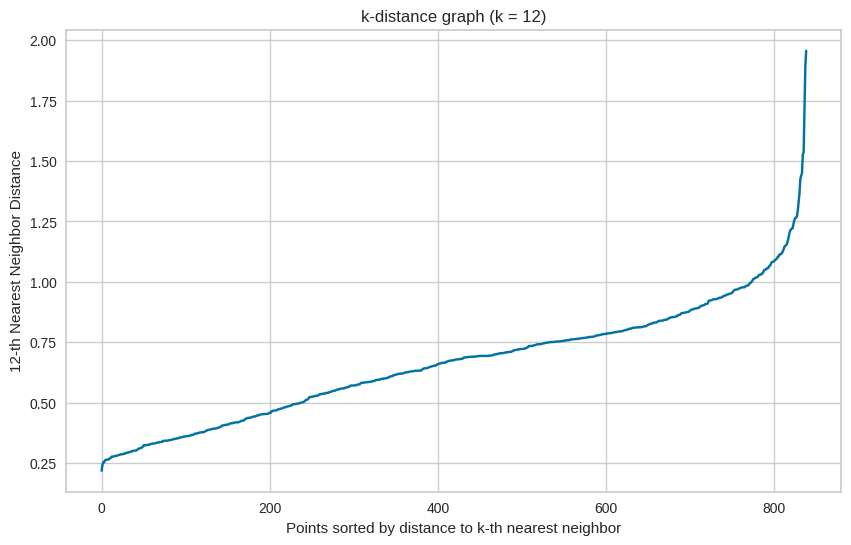

In [28]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

X = inliers_df

# Bước 1: Chọn giá trị min_samples (minpts) - thường là 5 hoặc 10 tùy thuộc vào dữ liệu
min_samples = 12  # Giá trị thử nghiệm

# Bước 2: Tính toán khoảng cách đến min_samples lân cận gần nhất
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sắp xếp các khoảng cách để tìm "góc gãy" trên đồ thị
distances = np.sort(distances[:, min_samples - 1])  # Chọn khoảng cách đến điểm lân cận thứ min_samples

# Bước 3: Vẽ đồ thị k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'k-distance graph (k = {min_samples})')
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


In [29]:
dbscan = DBSCAN(eps=1.1, min_samples=12)
dbscan_labels = dbscan.fit_predict(X)

# Count the number of clusters and noise points
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
clusters_info = dict(zip(unique_labels, counts))

clusters_info

{-1: 8, 0: 514, 1: 317}

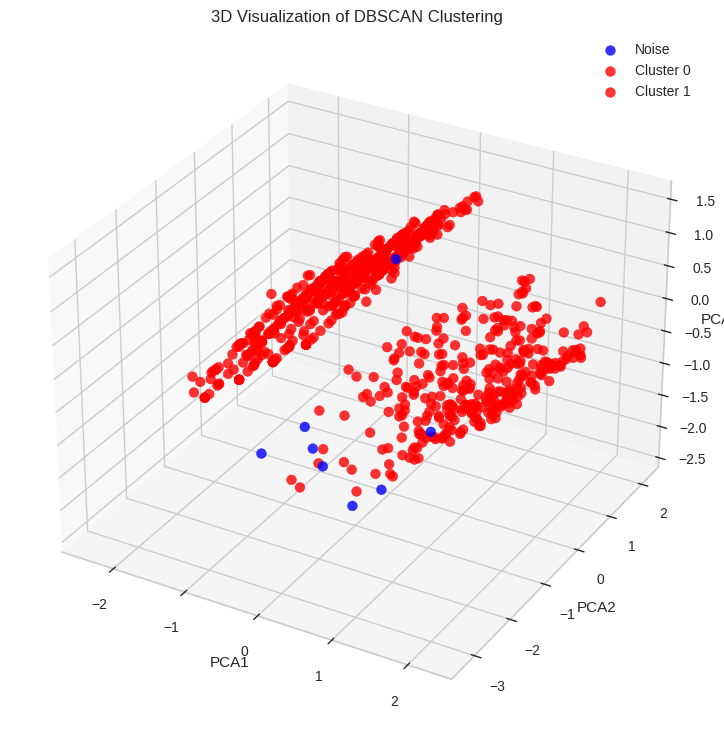

In [30]:

pca_3d = PCA(n_components=3)  # Initialize PCA with 3 components
inliers_pca_3d = pca_3d.fit_transform(inliers_df)

plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')

for label in np.unique(dbscan_labels):
    if label == -1:  # Noise
        color = [0, 0, 1, 1]  # Blue for noise
        label_name = "Noise"
    else:
        color = [1, 0, 0, 1]  # Red for clusters
        label_name = f"Cluster {label}"

    # Filter points belonging to the current cluster
    cluster_points = inliers_pca_3d[dbscan_labels == label]

    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               c=[color], label=label_name, s=50, alpha=0.8)

# Customize the plot
ax.set_title("3D Visualization of DBSCAN Clustering")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.legend(loc="best")
plt.show()

In [31]:
non_noise_mask = dbscan_labels != -1
X_non_noise = X[non_noise_mask]

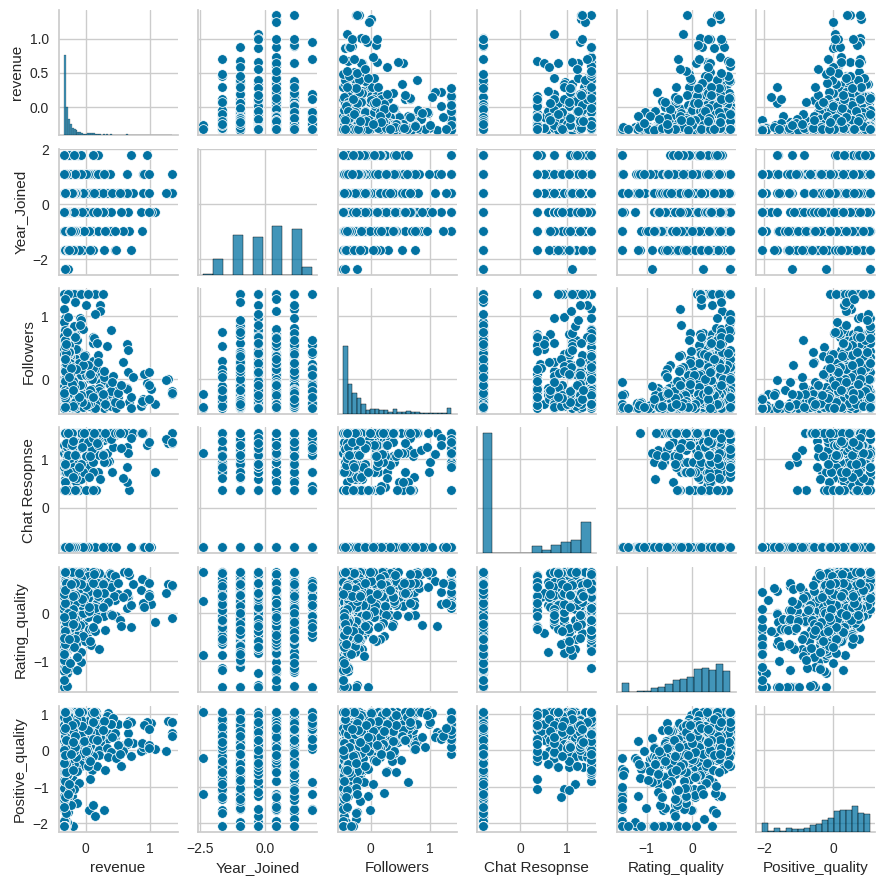

In [32]:
sns.pairplot(X_non_noise, height=1.5)
plt.show()

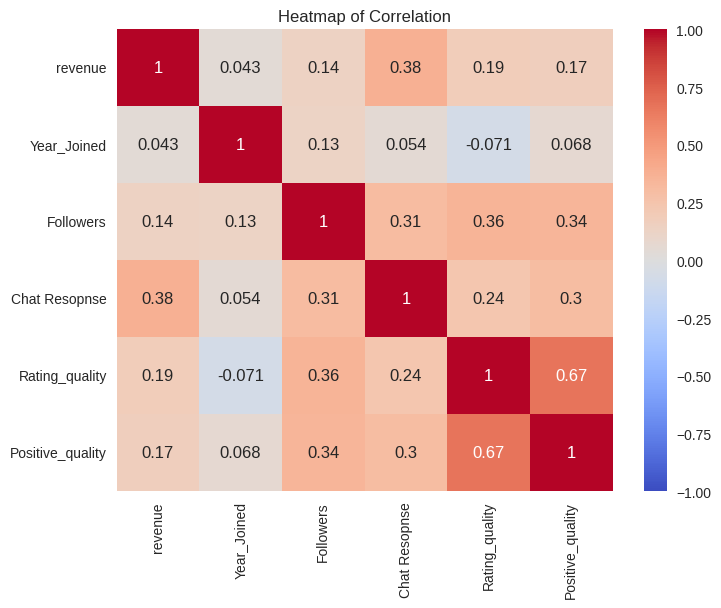

In [33]:
correlation_matrix = X_non_noise.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap of Correlation")
plt.show()

# ***`KMeans ++`***

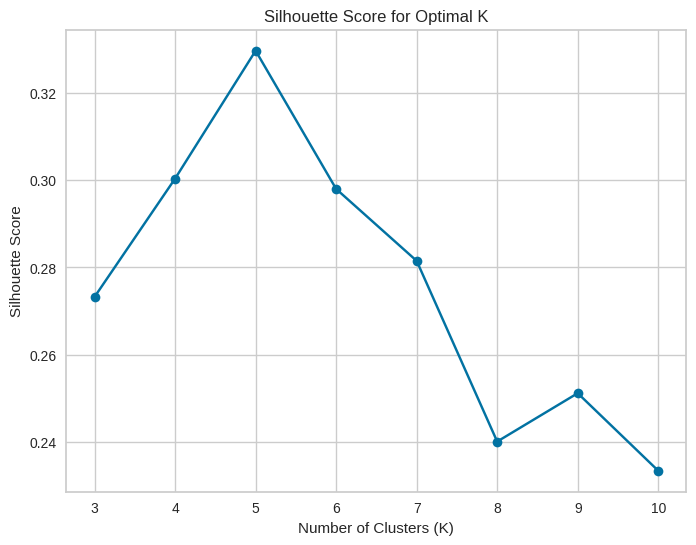

The optimal number of clusters is: 5
   Number of Clusters  Silhouette Score
0                   3          0.273251
1                   4          0.300402
2                   5          0.329759
3                   6          0.298026
4                   7          0.281516
5                   8          0.240029
6                   9          0.251132
7                  10          0.233334


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters_with_dataframe(data, max_clusters=10):
    """
    Tìm số cụm tối ưu và tạo bảng Silhouette Score từng cụm.

    Parameters:
    - data: Dữ liệu đầu vào (mảng numpy hoặc pandas DataFrame).
    - max_clusters: Số cụm tối đa để kiểm tra (mặc định là 10).

    Returns:
    - optimal_k: Số cụm tối ưu.
    - silhouette_df: DataFrame chứa Silhouette Score cho từng số cụm.
    """
    silhouette_scores = []
    cluster_range = range(3, max_clusters + 1)  # Thử nghiệm từ 2 đến max_clusters

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, init= 'k-means++',random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append({'Number of Clusters': k, 'Silhouette Score': silhouette_avg})

    # Chuyển danh sách silhouette_scores thành DataFrame
    silhouette_df = pd.DataFrame(silhouette_scores)

    # Vẽ đồ thị Silhouette Score
    plt.figure(figsize=(8, 6))
    plt.plot(silhouette_df['Number of Clusters'], silhouette_df['Silhouette Score'], marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Tìm số cụm tối ưu với Silhouette Score lớn nhất
    optimal_k = silhouette_df.loc[silhouette_df['Silhouette Score'].idxmax(), 'Number of Clusters']
    print(f"The optimal number of clusters is: {optimal_k}")

    return optimal_k, silhouette_df

# Ví dụ sử dụng:
# Giả sử `X_non_noise` là dữ liệu đã được tiền xử lý.
optimal_k, silhouette_df = find_optimal_clusters_with_dataframe(X_non_noise, max_clusters=10)

# In bảng kết quả
print(silhouette_df)


In [ ]:
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42)
kmeanlabels = kmeans.fit_predict(X_non_noise)

silhouette_avg = silhouette_score(X_non_noise, kmeanlabels)
print(f"Silhouette Score: {silhouette_avg}")

dbi_score = davies_bouldin_score(X_non_noise, kmeanlabels)
print(f"Davies-Bouldin Index (DBI): {dbi_score}")

chi_score = calinski_harabasz_score(X_non_noise, kmeanlabels)
print(f"Calinski-Harabasz Index (CHI): {chi_score}")

Silhouette Score: 0.32975947693015656
Davies-Bouldin Index (DBI): 1.0726596795256962
Calinski-Harabasz Index (CHI): 414.1770407341688


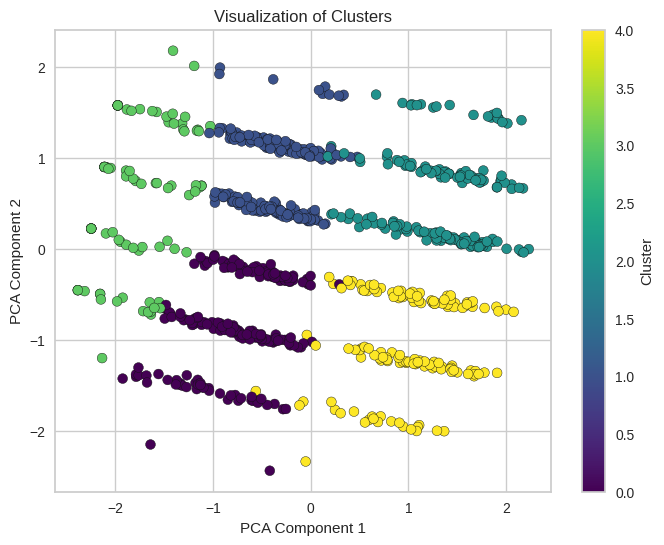

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise)

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeanlabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

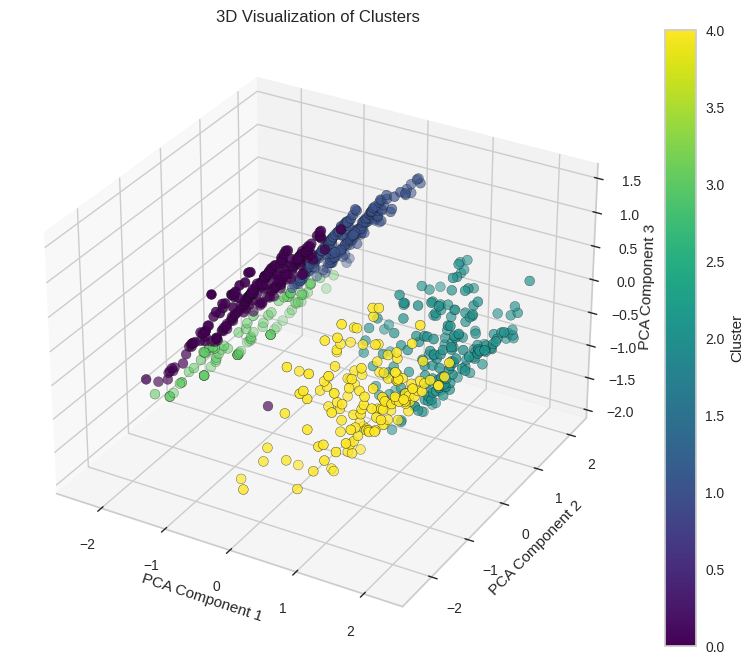

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise)

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeanlabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

# ***`Agglomerative Clustering`***

In [ ]:
X_non_noise.head(2)

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  
0          0.731572  
1          0.189270

Silhouette Scores for different numbers of clusters:
   Number of Clusters  Silhouette Score
0                   3          0.287882
1                   4          0.307923
2                   5          0.297408
3                   6          0.268597
4                   7          0.246244
5                   8          0.210636
6                   9          0.222362
7                  10          0.216999


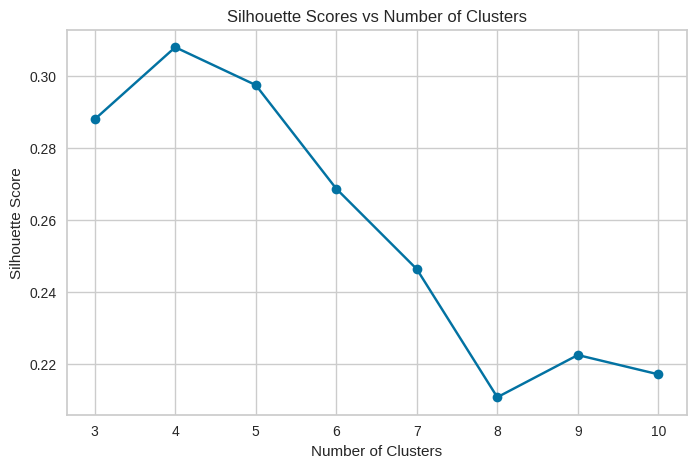

In [ ]:
k_values = range(3, 11)
silhouette_scores = []

# Lặp qua các số cụm
for k in k_values:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward', metric = 'euclidean')
    agglabels = clustering.fit_predict(X_non_noise)
    score = silhouette_score(X_non_noise, agglabels)
    silhouette_scores.append(score)

silhouette_table = pd.DataFrame({
    "Number of Clusters": k_values,
    "Silhouette Score": silhouette_scores
})

# Tìm số cụm tối ưu
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

print("Silhouette Scores for different numbers of clusters:")
print(silhouette_table)

# Vẽ đồ thị Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
# plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()

In [ ]:
aggclustering = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')
agglabels = aggclustering.fit_predict(X_non_noise)

score = silhouette_score(X_non_noise, agglabels)
print(f"Silhouette Score: {score}")

dbi_score = davies_bouldin_score(X_non_noise, agglabels)
print(f"Davies-Bouldin Index (DBI): {dbi_score}")

chi_score = calinski_harabasz_score(X_non_noise, agglabels)
print(f"Calinski-Harabasz Index (CHI): {chi_score}")

Silhouette Score: 0.30792262797625725
Davies-Bouldin Index (DBI): 1.0353450911872015
Calinski-Harabasz Index (CHI): 356.49202521654775


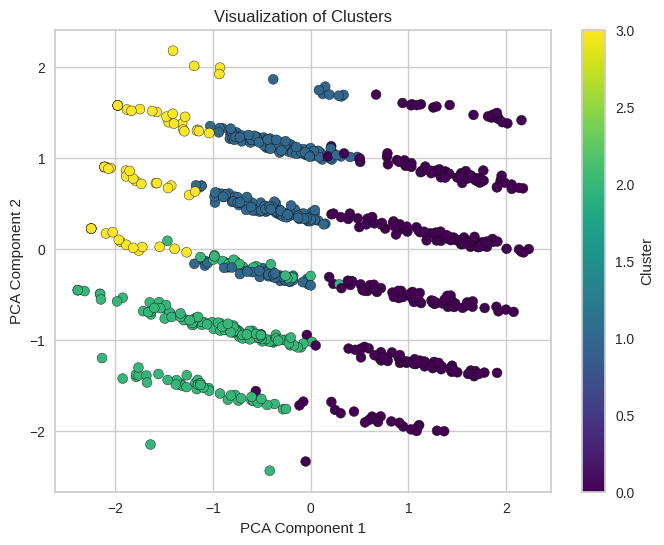

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise)

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

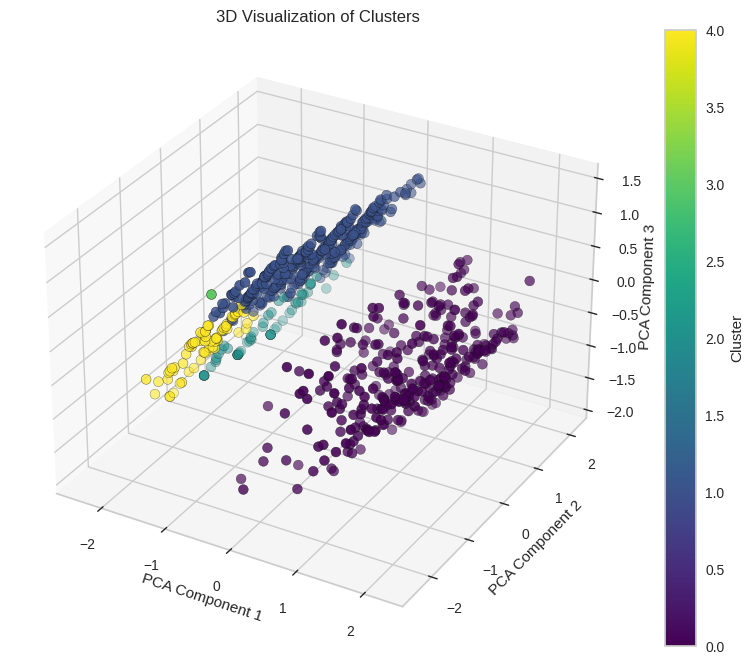

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise)

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=agglabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

# ***`GMM (Gaussian Mixture Model)`***

In [34]:
X_non_noise

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0   -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1   -0.143226    -0.972848   0.031235      -0.819518        0.539159   
2   -0.260906     0.413962   1.358861       1.525984        0.663007   
3   -0.313024     1.107368  -0.313240      -0.819518       -0.090066   
4   -0.287069     0.413962  -0.284224       1.525984        0.379822   
..        ...          ...        ...            ...             ...   
927 -0.321503    -2.359659  -0.442460      -0.819518        0.837530   
928  0.292289    -0.972848  -0.408721       1.525984       -0.349262   
929  0.176205    -0.279443   0.581516       1.314889        0.410154   
930 -0.203387    -1.666254  -0.183682       1.361799        0.353820   
932 -0.256463    -1.666254   0.032584      -0.819518       -0.544182   

     Positive_quality  
0            0.731572  
1            0.189270  
2            1.056228  
3            0.500853  
4            0.768611  
..                ...  
927          1.056228  
928         -0.545265  
929          0.269981  
930          0.214836  
932         -0.921882  

[831 rows x 6 columns]

   Number of Components    BIC Score
0                     3   408.769746
1                     4  -683.033094
2                     5  -833.456071
3                     6  -883.862365
4                     7  -842.052860
5                     8  -896.894997
6                     9 -1005.455572
7                    10  -922.503243


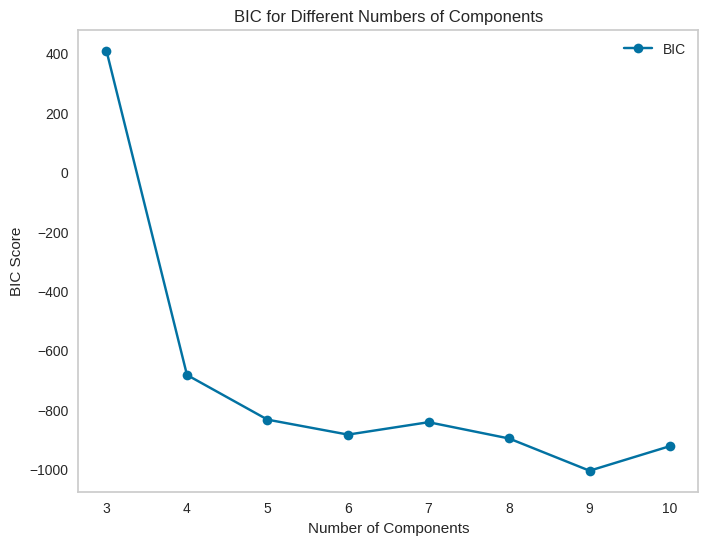

In [ ]:
# Phạm vi số cụm cần thử
n_components_range = range(3, 11)  # Thử từ 1 đến 9 cụm

# Lưu trữ kết quả BIC
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_non_noise)
    bic_scores.append(gmm.bic(X_non_noise))


bic_df = pd.DataFrame({
    "Number of Components": n_components_range,
    "BIC Score": bic_scores
})
print(bic_df)
# Vẽ biểu đồ BIC
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
# plt.axvline(optimal_n_components, linestyle='--', color='red', label=f'Optimal n_components: {optimal_n_components}')
plt.title('BIC for Different Numbers of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.legend()
plt.grid()
plt.show()

# print(f"Số cụm tối ưu (theo BIC): {optimal_n_components}")

In [ ]:
# Khởi tạo mô hình GMM với 6 cụm
# gmm = GaussianMixture(n_components=6, covariance_type='full', init_params='kmeans', max_iter=300, random_state=42)
gmm = GaussianMixture(n_components=4, covariance_type='full', max_iter=300, random_state=42)

gmm.fit(X_non_noise)
gmmlabels = gmm.predict(X_non_noise)

In [ ]:
print("AIC:", gmm.aic(X_non_noise))
print("BIC:", gmm.bic(X_non_noise))
print("Log-Likelihood:", gmm.score(X_non_noise))

AIC: -1207.2450008064834
BIC: -683.0330935775286
Log-Likelihood: 0.8599548741314581


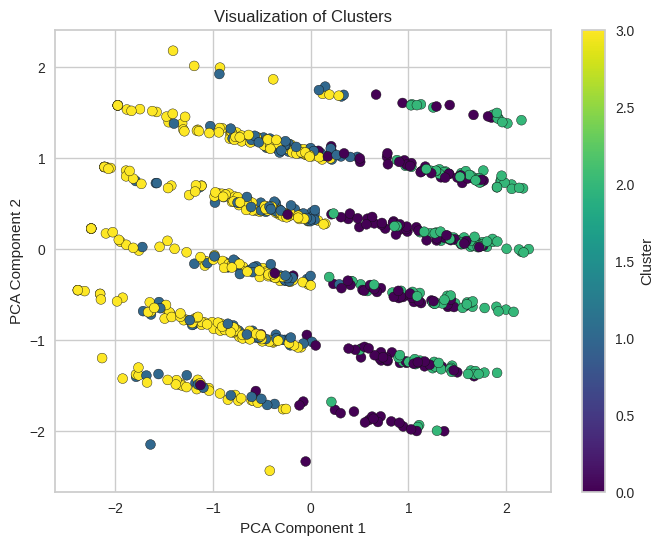

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise)

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmmlabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

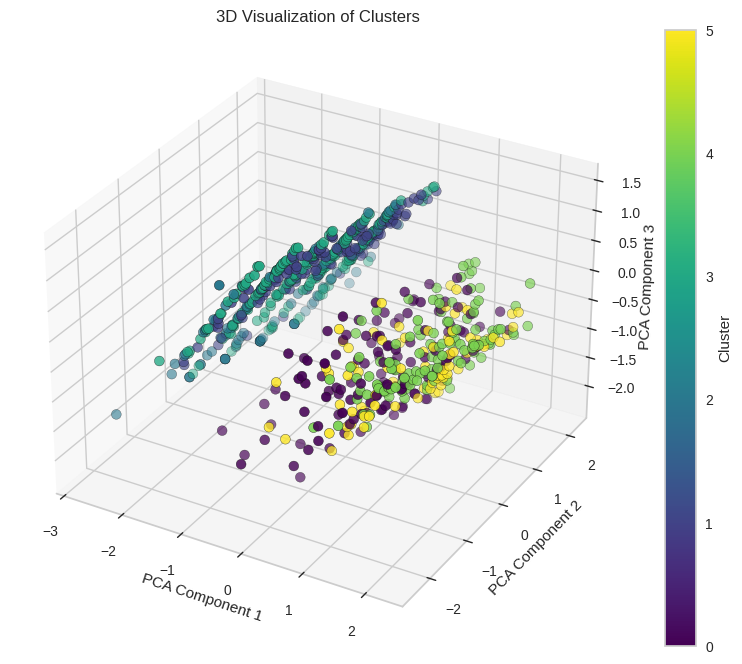

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise)

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=gmmlabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

# ***`FREQUENT ITEMSET`***

# ***`K-Bin Discritizer`***

In [ ]:
def apply_kmeans(column_data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    column_data = column_data.values.reshape(-1, 1)  # Reshape for single feature
    return kmeans.fit_predict(column_data)

# Apply K-Means to each column
clustered_columns = {}
for column in X_non_noise.columns:
    clustered_columns[column] = apply_kmeans(X_non_noise[column])

# Add the cluster labels to the DataFrame
for column, labels in clustered_columns.items():
    X_non_noise[f'{column}_class'] = labels


In [ ]:
X_non_noise.head(2)

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  revenue_class  Year_Joined_class  Followers_class  \
0          0.731572              1                  0                0   
1          0.189270              1                  0                2   

   Chat Resopnse_class  Rating_quality_class  Positive_quality_class  
0                    1                     0                       0  
1                    1                     0                       2

In [ ]:
min_max_df = X_non_noise.groupby('Positive_quality_class')['Positive_quality'].agg(['min', 'max'])
print(min_max_df)

                             min       max
Positive_quality_class                    
0                       0.238130  1.056228
1                      -2.078343 -0.912847
2                      -0.890794  0.235858


In [ ]:
# Revenue
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(0, "High")
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(1, "Low")
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(2, "Medium")
#Year_Joined
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(0, "Medium")
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(1, "High")
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(2, "Low")
# Followers
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(0, "Low")
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(1, "High")
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(2, "Medim")
# Chat Resopnse
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(0, "Medium")
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(1, "Low")
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(2, "High")
#Rating Quality
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(0, "High")
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(1, "Medium")
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(2, "Low")
#positive
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(0, "High")
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(1, "Low")
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(2, "Medium")

In [ ]:
X_non_noise.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_discretization.xlsx')

# ***`FP-Max`***

In [ ]:
X_non_noise_cate = X_non_noise.iloc[:, 6:]
X_non_noise_dummies = pd.get_dummies(X_non_noise_cate)

In [ ]:
item_count = {}
for col in X_non_noise_dummies.columns:
    item_count[col] = X_non_noise_dummies[col].sum()
item_freq_df = pd.DataFrame(data=list(item_count.values()), index=list(item_count.keys()), columns=['frequency']).sort_values(by='frequency', ascending=False)
item_freq_df.shape, item_freq_df

((18, 1),
                                frequency
 revenue_class_Low                    693
 Followers_class_Low                  625
 Chat Resopnse_class_Low              514
 Rating_quality_class_High            480
 Year_Joined_class_High               432
 Positive_quality_class_High          426
 Year_Joined_class_Medium             330
 Positive_quality_class_Medium        313
 Rating_quality_class_Medium          274
 Chat Resopnse_class_High             211
 Followers_class_Medim                145
 Chat Resopnse_class_Medium           106
 revenue_class_Medium                 106
 Positive_quality_class_Low            92
 Rating_quality_class_Low              77
 Year_Joined_class_Low                 69
 Followers_class_High                  61
 revenue_class_High                    32)

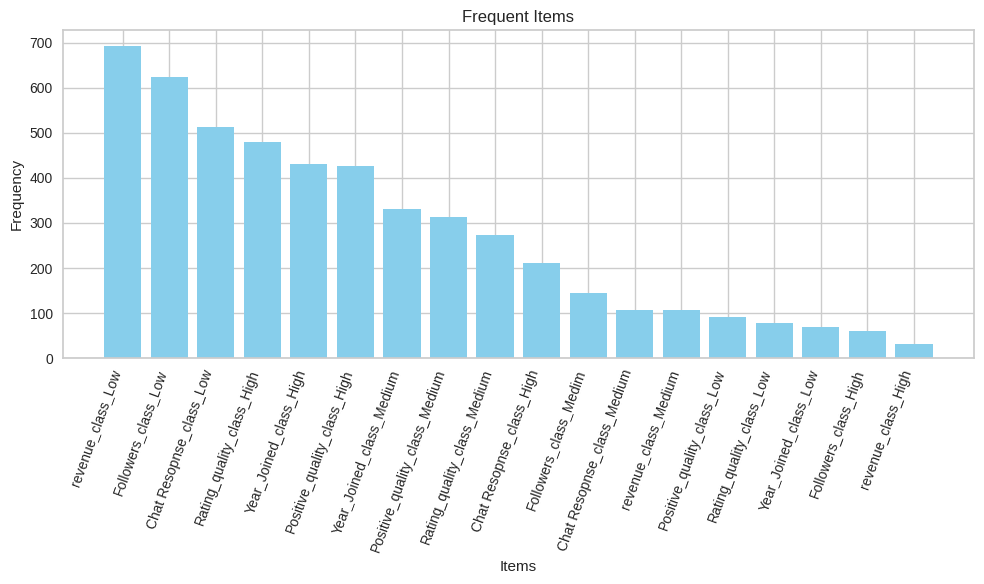

In [ ]:
# Calculate the sum of each column (representing the frequency of each item)
column_sums = X_non_noise_dummies.sum()
# Sort the columns by sum in descending order
sorted_columns = column_sums.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_columns.index, sorted_columns.values, color='skyblue')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Frequent Items')
plt.xticks(rotation=70, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
from mlxtend.frequent_patterns import fpmax

# Tìm các tập mục phổ biến tối đại
frequent_itemsets = fpmax(X_non_noise_dummies, min_support=0.2, use_colnames=True)
frequent_itemsets = pd.DataFrame(frequent_itemsets)

In [ ]:
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets = pd.DataFrame(frequent_itemsets)
print(frequent_itemsets)

     support                                           itemsets
8   0.262335  (revenue_class_Low, Year_Joined_class_Medium, ...
3   0.257521  (revenue_class_Low, Rating_quality_class_Mediu...
0   0.253911                         (Chat Resopnse_class_High)
15  0.252708  (revenue_class_Low, Year_Joined_class_High, Fo...
10  0.244284  (Positive_quality_class_High, revenue_class_Lo...
5   0.243081  (Rating_quality_class_High, Year_Joined_class_...
7   0.237064  (revenue_class_Low, Year_Joined_class_Medium, ...
14  0.225030  (Rating_quality_class_High, revenue_class_Low,...
16  0.225030  (Rating_quality_class_High, revenue_class_Low,...
12  0.223827  (Positive_quality_class_High, revenue_class_Lo...
6   0.211793  (Year_Joined_class_Medium, Followers_class_Low...
4   0.210590  (Positive_quality_class_Medium, revenue_class_...
11  0.208183  (Rating_quality_class_High, Positive_quality_c...
2   0.206980  (Rating_quality_class_Medium, Followers_class_...
1   0.205776  (revenue_class_Low, Rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
frequent_itemsets.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_fpmax.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# ***`New Features`***

In [ ]:
X_non_noise.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality revenue_class Year_Joined_class Followers_class  \
0          0.731572           Low            Medium             Low   
1          0.189270           Low            Medium           Medim   

  Chat Resopnse_class Rating_quality_class Positive_quality_class  
0                 Low                 High                   High  
1                 Low                 High                 Medium

In [ ]:
# 1. 'revenue_class_Low', 'Year_Joined_class_Medium', 'Followers_class_Low'
X_non_noise['revenue_Low_Year_Medium_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 2. 'revenue_class_Low', 'Rating_quality_class_Medium', 'Followers_class_Low'
X_non_noise['revenue_Low_Rating_Medium_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 3. 'Chat Resopnse_class_High'
X_non_noise['Chat_Resopnse_High'] = (X_non_noise['Chat Resopnse_class'] == 'High').astype(int)

# 4. 'revenue_class_Low', 'Year_Joined_class_High', 'Followers_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['revenue_Low_Year_High_Followers_Low_Chat_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'High') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 5. 'Positive_quality_class_High', 'revenue_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['Positive_High_revenue_Low_Chat_Low'] = (
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 6. 'Rating_quality_class_High', 'Year_Joined_class_Medium'
X_non_noise['Rating_High_Year_Medium'] = (
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['Year_Joined_class'] == 'Medium')
).astype(int)

# 7. 'revenue_class_Low', 'Year_Joined_class_Medium', 'Chat Resopnse_class_Low'
X_non_noise['revenue_Low_Year_Medium_Chat_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'Medium') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 8. 'Rating_quality_class_High', 'revenue_class_Low', 'Year_Joined_class_High'
X_non_noise['Rating_High_revenue_Low_Year_High'] = (
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'High')
).astype(int)

# 9. 'Rating_quality_class_High', 'revenue_class_Low', 'Followers_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['Rating_High_revenue_Low_Followers_Low_Chat_Low'] = (
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 10. 'Positive_quality_class_High', 'revenue_class_Low', 'Year_Joined_class_High'
X_non_noise['Positive_High_revenue_Low_Year_High'] = (
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'High')
).astype(int)

# 11. 'Year_Joined_class_Medium', 'Followers_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['Year_Medium_Followers_Low_Chat_Low'] = (
    (X_non_noise['Year_Joined_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 12. 'Positive_quality_class_Medium', 'revenue_class_Low', 'Followers_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['Positive_Medium_revenue_Low_Followers_Low_Chat_Low'] = (
    (X_non_noise['Positive_quality_class'] == 'Medium') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 13. 'Rating_quality_class_High', 'Positive_quality_class_High', 'Year_Joined_class_High'
X_non_noise['Rating_High_Positive_High_Year_High'] = (
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Year_Joined_class'] == 'High')
).astype(int)

# 14. 'Rating_quality_class_Medium', 'Followers_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['Rating_Medium_Followers_Low_Chat_Low'] = (
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 15. 'revenue_class_Low', 'Rating_quality_class_Medium', 'Chat Resopnse_class_Low'
X_non_noise['revenue_Low_Rating_Medium_Chat_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 16. 'Positive_quality_class_High', 'Followers_class_Low', 'Chat Resopnse_class_Low'
X_non_noise['Positive_High_Followers_Low_Chat_Low'] = (
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 17. 'Rating_quality_class_High', 'Positive_quality_class_High', 'revenue_class_Low', 'Followers_class_Low'
X_non_noise['Rating_High_Positive_High_revenue_Low_Followers_Low'] = (
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
X_non_noise.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality revenue_class Year_Joined_class Followers_class  \
0          0.731572           Low            Medium             Low   
1          0.189270           Low            Medium           Medim   

  Chat Resopnse_class  ... Rating_High_revenue_Low_Year_High  \
0                 Low  ...                                 0   
1                 Low  ...                                 0   

  Rating_High_revenue_Low_Followers_Low_Chat_Low  \
0                                              1   
1                                              0   

   Positive_High_revenue_Low_Year_High  Year_Medium_Followers_Low_Chat_Low  \
0                                    0                                   1   
1                                    0                                   0   

   Positive_Medium_revenue_Low_Followers_Low_Chat_Low  \
0                                                  0    
1                                                  0    

   Rating_High_Positive_High_Year_High  Rating_Medium_Followers_Low_Chat_Low  \
0                                    0                                     0   
1                                    0                                     0   

   revenue_Low_Rating_Medium_Chat_Low  Positive_High_Followers_Low_Chat_Low  \
0                                   0                                     1   
1                                   0                                     0   

   Rating_High_Positive_High_revenue_Low_Followers_Low  
0                                                  1    
1                                                  0    

[2 rows x 29 columns]

In [ ]:
X_non_noise_final = X_non_noise.drop(columns = ['revenue_class', 'Year_Joined_class', 'Followers_class', 'Chat Resopnse_class', 'Rating_quality_class', 'Positive_quality_class'])
X_non_noise_final.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  revenue_Low_Year_Medium_Followers_Low  \
0          0.731572                                      1   
1          0.189270                                      0   

   revenue_Low_Rating_Medium_Followers_Low  Chat_Resopnse_High  \
0                                        0                   0   
1                                        0                   0   

   revenue_Low_Year_High_Followers_Low_Chat_Low  ...  \
0                                             0  ...   
1                                             0  ...   

   Rating_High_revenue_Low_Year_High  \
0                                  0   
1                                  0   

   Rating_High_revenue_Low_Followers_Low_Chat_Low  \
0                                               1   
1                                               0   

   Positive_High_revenue_Low_Year_High  Year_Medium_Followers_Low_Chat_Low  \
0                                    0                                   1   
1                                    0                                   0   

   Positive_Medium_revenue_Low_Followers_Low_Chat_Low  \
0                                                  0    
1                                                  0    

   Rating_High_Positive_High_Year_High  Rating_Medium_Followers_Low_Chat_Low  \
0                                    0                                     0   
1                                    0                                     0   

   revenue_Low_Rating_Medium_Chat_Low  Positive_High_Followers_Low_Chat_Low  \
0                                   0                                     1   
1                                   0                                     0   

   Rating_High_Positive_High_revenue_Low_Followers_Low  
0                                                  1    
1                                                  0    

[2 rows x 23 columns]

In [ ]:
X_non_noise_final.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# ***`CLUSTERING AFTER USING FREQUENT ITEMSET`***

# ***`Forward Selection for K-Means`***

In [ ]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
from gower import gower_matrix

def gower_distance(data):
    return gower_matrix(data)

X_continuous = X_non_noise_final_continuous
binary_features = X_non_noise_final_categorical
best_silhouette_score = -1
selected_features = X_continuous.copy()

while not binary_features.empty:
    best_feature = None
    for binary_feature_name in binary_features.columns:
        print("Binary Feature Name là: ", binary_feature_name)

        # Thêm biến nhị phân hiện tại vào tập dữ liệu
        current_features = selected_features.copy()
        current_features[binary_feature_name] = binary_features[binary_feature_name]
        print("Current Features: ", current_features.columns)

        # Cập nhật các cột phân loại: Chỉ số các cột nhị phân mới thêm vào sẽ tiếp tục nối vào cuối danh sách
        categorical_columns_indices = list(range(len(X_continuous.columns), len(current_features.columns)))
        print("Categorical Columns Indices: ", categorical_columns_indices)

        # Áp dụng K-Prototypes
        kproto = KPrototypes(n_clusters=5, init='Cao', random_state=100)
        kmeansclusters = kproto.fit_predict(current_features, categorical=categorical_columns_indices)

        # Tính khoảng cách Gower cho dữ liệu hỗn hợp
        k_gower_distances = gower_distance(current_features)

        # Tính Silhouette Score với khoảng cách Gower
        silhouette_avg = silhouette_score(k_gower_distances, kmeansclusters, metric="precomputed")
        print("Silhouette Avg:", silhouette_avg)

        # Kiểm tra nếu Silhouette Score cải thiện, cập nhật biến tốt nhất
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_feature = binary_feature_name
    print("Best Silhouette Score: ", best_silhouette_score)
    print('Best Features', best_feature)
    print('Kết thúc vòng lặp.')
    print('_______________________________________________')

    # Nếu không có biến nào cải thiện Silhouette Score, dừng
    if best_feature is None:
        break

    # Thêm biến tốt nhất vào tập biến đã chọn
    selected_features[best_feature] = binary_features[best_feature]
    print("Selected Features: ", selected_features)

    # Loại bỏ biến đã chọn khỏi danh sách biến còn lại
    binary_features = binary_features.drop(columns=[best_feature])
    print("Binary Features: ", binary_features.columns)

print("binary_features Empty")
print("____________________________________________")
# Thêm nhãn cụm vào DataFrame
selected_features['Cluster'] = kmeansclusters

# In kết quả
print("Selected features: ", selected_features.columns[:-1])
print("Best Silhouette Score (dữ liệu hỗn hợp):", best_silhouette_score)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Binary Feature Name là:  revenue_Low_Year_Medium_Followers_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Year_Medium_Followers_Low'],
      dtype='object')
Categorical Columns Indices:  [6]
Silhouette Avg: 0.2623685
Binary Feature Name là:  revenue_Low_Rating_Medium_Followers_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Rating_Medium_Followers_Low'],
      dtype='object')
Categorical Columns Indices:  [6]
Silhouette Avg: 0.18679988
Binary Feature Name là:  Chat_Resopnse_High
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality', 'Chat_Resopnse_High'],
      dtype='object')
Categorical Columns Indices:  [6]
Silhouette Avg: 0.19540025
Binary Feature Name là:  revenue_Low_Year_High_Followers_Low_Chat_Low
Curren

# ***`Final Clustering`***

In [ ]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:

# Danh sách các cột đặc trưng
feature_names = ['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Year_High_Followers_Low_Chat_Low',
       'Rating_High_Year_Medium', 'revenue_Low_Year_Medium_Chat_Low']

# Chọn dữ liệu không nhiễu với các đặc trưng cần thiết
X_non_noise_final_1 = X_non_noise_final[feature_names]

# Chỉ định các cột phân loại (categorical), cần đánh số 0-based
categorical_columns_indices = [6, 7, 8]  # Các cột này là dữ liệu phân loại

# Áp dụng K-Prototypes
kproto = KPrototypes(n_clusters=5, init='Cao', random_state=42)
clusters = kproto.fit_predict(X_non_noise_final_1, categorical=categorical_columns_indices)

# Thêm nhãn cụm vào DataFrame gốc
X_non_noise_final_1['Cluster'] = clusters

# Tính khoảng cách Gower cho dữ liệu hỗn hợp
gower_distances = gower_matrix(X_non_noise_final_1)

# Tính Silhouette Score với khoảng cách Gower
silhouette_avg = silhouette_score(gower_distances, X_non_noise_final_1['Cluster'], metric="precomputed")

# Tính Davies-Bouldin Index với khoảng cách Gower
davies_bouldin_avg = davies_bouldin_score(gower_distances, X_non_noise_final_1['Cluster'])

dbi = davies_bouldin_score(gower_distances, X_non_noise_final_1['Cluster'])
chi = calinski_harabasz_score(gower_distances, X_non_noise_final_1['Cluster'])

# In kết quả đánh giá
print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
print("Davies-Bouldin Index (dữ liệu hỗn hợp):", dbi)
print(f"Calinski-Harabasz Index (CHI): {chi}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Silhouette Score (dữ liệu hỗn hợp): 0.43934333
Davies-Bouldin Index (dữ liệu hỗn hợp): 0.9888413923741999
Calinski-Harabasz Index (CHI): 579.031800144176


# ***`Visualize`***

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



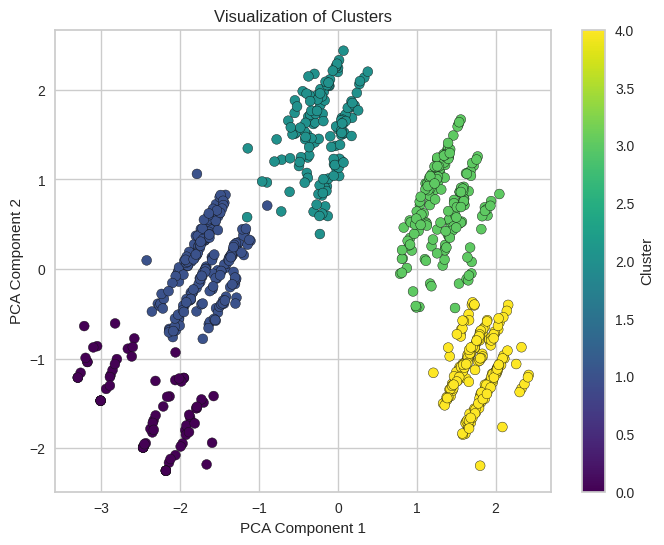

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final_1)

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



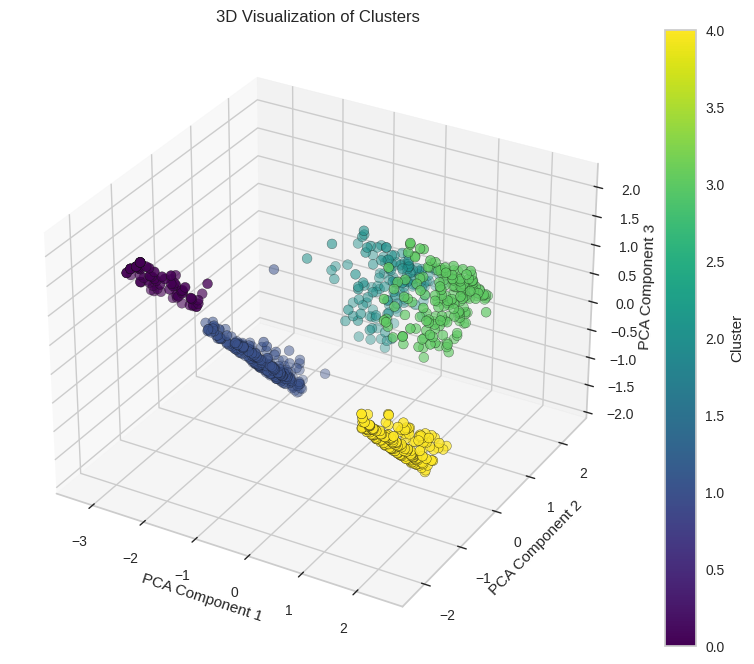

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final_1)

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

# ***`Forward Selection for Agglomerative Clustering`***

In [ ]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

# Hàm tính khoảng cách Gower
def gower_distance(data):
    return gower_matrix(data)

X_continuous = X_non_noise_final_continuous
binary_features = X_non_noise_final_categorical
best_silhouette_score = -1
selected_features = X_continuous.copy()


while not binary_features.empty:
    best_feature = None
    for binary_feature_name in binary_features.columns:
        print("Binary Feature Name là: ", binary_feature_name)

        # Thêm biến nhị phân hiện tại vào tập dữ liệu
        current_features = selected_features.copy()
        current_features[binary_feature_name] = binary_features[binary_feature_name]
        print("Current Features: ", current_features.columns)

        # Tính khoảng cách Gower cho dữ liệu hỗn hợp
        gower_distances = gower_distance(current_features)

        # Áp dụng Agglomerative Clustering
        clustering = AgglomerativeClustering(n_clusters=4, metric="precomputed", linkage="average")
        clusters = clustering.fit_predict(gower_distances)

        # Tính Silhouette Score với khoảng cách Gower
        silhouette_avg = silhouette_score(gower_distances, clusters, metric="precomputed")
        print("Silhouette Avg:", silhouette_avg)

        # Kiểm tra nếu Silhouette Score cải thiện, cập nhật biến tốt nhất
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_feature = binary_feature_name
    print("Best Silhouette Score: ", best_silhouette_score)
    print('Kết thúc vòng lặp.')

    # Nếu không có biến nào cải thiện Silhouette Score, dừng
    if best_feature is None:
        break

    # Thêm biến tốt nhất vào tập biến đã chọn
    selected_features[best_feature] = binary_features[best_feature]
    print("Selected Features: ", selected_features)

    # Loại bỏ biến đã chọn khỏi danh sách biến còn lại
    binary_features = binary_features.drop(columns=[best_feature])
    print("Binary Features: ", binary_features.columns)

# Thêm nhãn cụm vào DataFrame
selected_features['Cluster'] = clusters

# Tính các chỉ số đánh giá khác
gower_distances = gower_distance(selected_features)

# In kết quả
print("Selected features: ", selected_features.columns[:-1])
print("Best Silhouette Score (dữ liệu hỗn hợp):", best_silhouette_score)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Binary Feature Name là:  revenue_Low_Year_Medium_Followers_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Year_Medium_Followers_Low'],
      dtype='object')
Silhouette Avg: 0.37504274
Binary Feature Name là:  revenue_Low_Rating_Medium_Followers_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Rating_Medium_Followers_Low'],
      dtype='object')
Silhouette Avg: 0.3692638
Binary Feature Name là:  Chat_Resopnse_High
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality', 'Chat_Resopnse_High'],
      dtype='object')
Silhouette Avg: 0.3451965
Binary Feature Name là:  revenue_Low_Year_High_Followers_Low_Chat_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'P

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from gower import gower_matrix

# Danh sách các cột đặc trưng
feature_names = ['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'Rating_Medium_Followers_Low_Chat_Low',
       'Rating_High_revenue_Low_Followers_Low_Chat_Low',
       'revenue_Low_Rating_Medium_Chat_Low']

# Chọn dữ liệu không nhiễu với các đặc trưng cần thiết
X_non_noise_final_2 = X_non_noise_final[feature_names]

# Tính khoảng cách Gower cho dữ liệu hỗn hợp
gower_distances = gower_matrix(X_non_noise_final_2)
clustering = AgglomerativeClustering(n_clusters=4, linkage='average', metric='precomputed')
fagglabels = clustering.fit_predict(gower_distances)

# # Thêm nhãn cụm vào DataFrame gốc
X_non_noise_final_2['Cluster'] = fagglabels

# Tính Silhouette Score với khoảng cách Gower
silhouette_avg = silhouette_score(gower_distances, X_non_noise_final_2['Cluster'], metric="precomputed")

# Tính Davies-Bouldin Index với khoảng cách Gower
davies_bouldin_avg = davies_bouldin_score(gower_distances, X_non_noise_final_2['Cluster']) # Calculate DBI using the original data

# # Tính Calinski-Harabasz Index với khoảng cách Gower
chi = calinski_harabasz_score(gower_distances, X_non_noise_final_2['Cluster'])

# In kết quả đánh giá
print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
print("Davies-Bouldin Index (dữ liệu hỗn hợp):", davies_bouldin_avg)
print("Calinski-Harabasz Index (CHI):", chi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Silhouette Score (dữ liệu hỗn hợp): 0.55252355
Davies-Bouldin Index (dữ liệu hỗn hợp): 0.6281051039092262
Calinski-Harabasz Index (CHI): 1451.0593305951759


In [ ]:
X_non_noise_final_2['Cluster'].unique()

array([2, 0, 1, 5, 3, 4])

# ***`Visualize `***

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



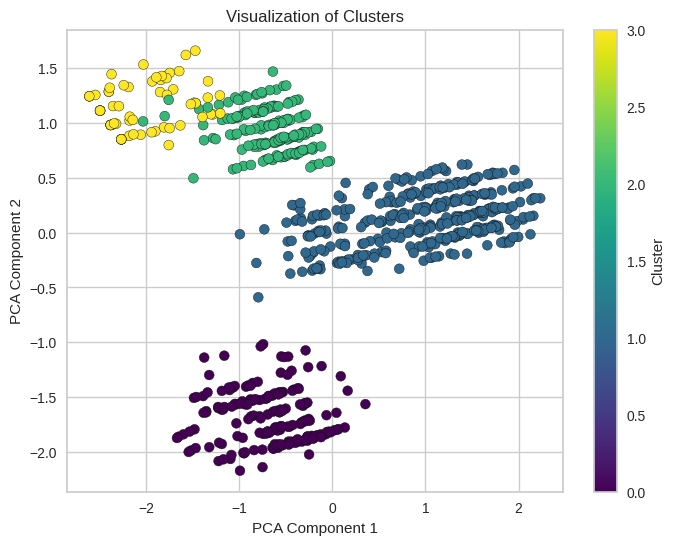

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fagglabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



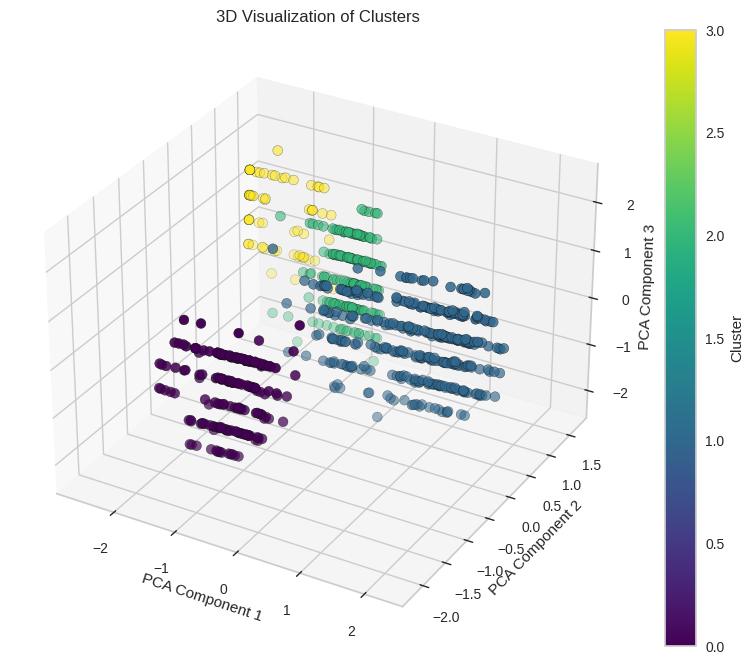

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=fagglabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Giả sử fagglabels là các nhãn cụm (thay đổi tùy theo dữ liệu của bạn)
df = pd.DataFrame(X_pca, columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
df['Cluster'] = fagglabels  # Gắn nhãn cụm vào DataFrame

# Sử dụng Plotly để vẽ biểu đồ 3D với các cụm màu sắc khác nhau
fig = px.scatter_3d(df,
                    x='PCA Component 1',
                    y='PCA Component 2',
                    z='PCA Component 3',
                    color='Cluster',   # Tô màu theo nhãn cụm
                    title='3D Visualization of Clusters',
                    color_continuous_scale='viridis',  # Bảng màu
                    labels={'Cluster': 'Cluster'},    # Đặt nhãn cho cột cụm
                    opacity=0.7)  # Đặt độ trong suốt của các điểm

# Hiển thị biểu đồ 3D tương tác (xoay, zoom)
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# ***`Forward Selection for GMM`***

In [5]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_continuous = X_non_noise_final.iloc[:, :6]
X_categorical = X_non_noise_final.iloc[:, 6:]

In [37]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd

# Dữ liệu ban đầu
X_continuous = X_non_noise_final.iloc[:, :6]
X_categorical = X_non_noise_final.iloc[:, 6:]

# Hàm tính AIC, BIC, Log-likelihood
def evaluate_model(X_train, n_components=4):
    # Khởi tạo và huấn luyện GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type= 'full', random_state=42 )
    gmm.fit(X_train)

    # Đánh giá mô hình
    log_likelihood = gmm.score(X_train) * len(X_train)  # Log-likelihood
    aic = gmm.aic(X_train)
    bic = gmm.bic(X_train)
    return log_likelihood, aic, bic

# Khởi tạo danh sách các đặc trưng và thông tin về mô hình
selected_features = X_continuous.columns.tolist()  # Bắt đầu với X_continuous
best_log_likelihood, best_aic, best_bic = evaluate_model(X_continuous)

# Danh sách lưu trữ các chỉ số cho mỗi bước
history = [(best_log_likelihood, best_aic, best_bic, selected_features)]

# Forward selection: thêm từng đặc trưng mới từ X_categorical
for iteration in range(len(X_categorical.columns)):
    best_feature = None
    best_feature_log_likelihood = -np.inf  # Khởi tạo thấp nhất có thể
    best_feature_aic = np.inf  # Khởi tạo lớn nhất có thể
    best_feature_bic = np.inf  # Khởi tạo lớn nhất có thể

    # Tìm đặc trưng tốt nhất trong X_categorical
    for feature in X_categorical.columns:
        if feature not in selected_features:
            # Thêm đặc trưng vào X_train
            current_features = selected_features + [feature]
            X_train = X_non_noise_final[current_features]

            # Đánh giá mô hình mới
            log_likelihood, aic, bic = evaluate_model(X_train)

            # Nếu đặc trưng này cải thiện mô hình, lưu lại
            if log_likelihood > best_feature_log_likelihood and aic < best_feature_aic and bic < best_feature_bic:
                best_feature = feature
                best_feature_log_likelihood = log_likelihood
                best_feature_aic = aic
                best_feature_bic = bic

    # Nếu có đặc trưng cải thiện, thêm vào mô hình
    if best_feature is not None:
        selected_features.append(best_feature)
        history.append((best_feature_log_likelihood, best_feature_aic, best_feature_bic, selected_features))

        # In ra thông tin về đặc trưng được chọn
        print(f"Selected feature: {best_feature} - Log-likelihood: {best_feature_log_likelihood}, AIC: {best_feature_aic}, BIC: {best_feature_bic}")

        # Loại bỏ đặc trưng đã chọn khỏi X_categorical
        X_categorical = X_categorical.drop(columns=[best_feature])
    else:
        print("No improvement found in this iteration.")
        break  # Nếu không có cải thiện, dừng lại

# Kết quả cuối cùng
print("\nFinal selected features:", selected_features)


Selected feature: Positive_High_revenue_Low_Chat_Low - Log-likelihood: 5418.391804872981, AIC: -10550.783609745962, BIC: -9875.447549081633
Selected feature: Positive_Medium_revenue_Low_Followers_Low_Chat_Low - Log-likelihood: 10128.676822265517, AIC: -19899.353644531035, BIC: -19054.002911251908
Selected feature: Chat_Resopnse_High - Log-likelihood: 13224.089338535301, AIC: -26010.178677070602, BIC: -24975.92275199726
Selected feature: Positive_High_Followers_Low_Chat_Low - Log-likelihood: 15697.366521805827, AIC: -30868.733043611654, BIC: -29626.68140756467
Selected feature: revenue_Low_Year_Medium_Chat_Low - Log-likelihood: 17349.801158954924, AIC: -34077.60231790985, BIC: -32608.864451709804
Selected feature: Year_Medium_Followers_Low_Chat_Low - Log-likelihood: 20506.69050963937, AIC: -40287.38101927874, BIC: -38573.06640374621
Selected feature: revenue_Low_Year_Medium_Followers_Low - Log-likelihood: 23384.702422988295, AIC: -45931.40484597659, BIC: -43952.62296193216
Selected feat

In [38]:
X_non_noise_final[selected_features]

['revenue',
 'Year_Joined',
 'Followers',
 'Chat Resopnse',
 'Rating_quality',
 'Positive_quality',
 'Positive_High_revenue_Low_Chat_Low',
 'Positive_Medium_revenue_Low_Followers_Low_Chat_Low',
 'Chat_Resopnse_High',
 'Positive_High_Followers_Low_Chat_Low',
 'revenue_Low_Year_Medium_Chat_Low',
 'Year_Medium_Followers_Low_Chat_Low',
 'revenue_Low_Year_Medium_Followers_Low',
 'Rating_High_revenue_Low_Followers_Low_Chat_Low',
 'revenue_Low_Rating_Medium_Chat_Low',
 'Positive_High_revenue_Low_Year_High',
 'Rating_Medium_Followers_Low_Chat_Low',
 'Rating_High_Positive_High_revenue_Low_Followers_Low',
 'revenue_Low_Year_High_Followers_Low_Chat_Low',
 'Rating_High_revenue_Low_Year_High',
 'Rating_High_Positive_High_Year_High',
 'Rating_High_Year_Medium',
 'revenue_Low_Rating_Medium_Followers_Low']

In [40]:
# Khởi tạo mô hình GMM với 6 cụm
# gmm = GaussianMixture(n_components=6, covariance_type='full', init_params='kmeans', max_iter=300, random_state=42)
fgmm = GaussianMixture(n_components=4, covariance_type='full', max_iter=300, random_state=42)

fgmm.fit(X_non_noise_final[selected_features])
fgmmlabels = gmm.predict(X_non_noise_final[selected_features])

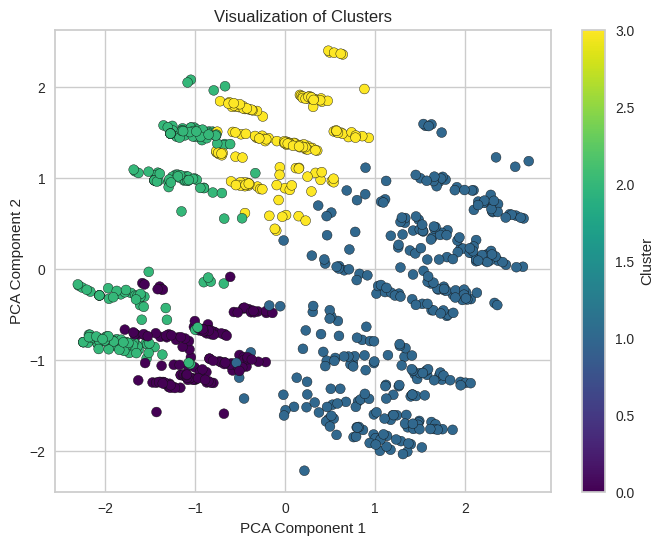

In [42]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final[selected_features])

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
# Use fgmmlabels instead of fgmm for the color argument
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fgmmlabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

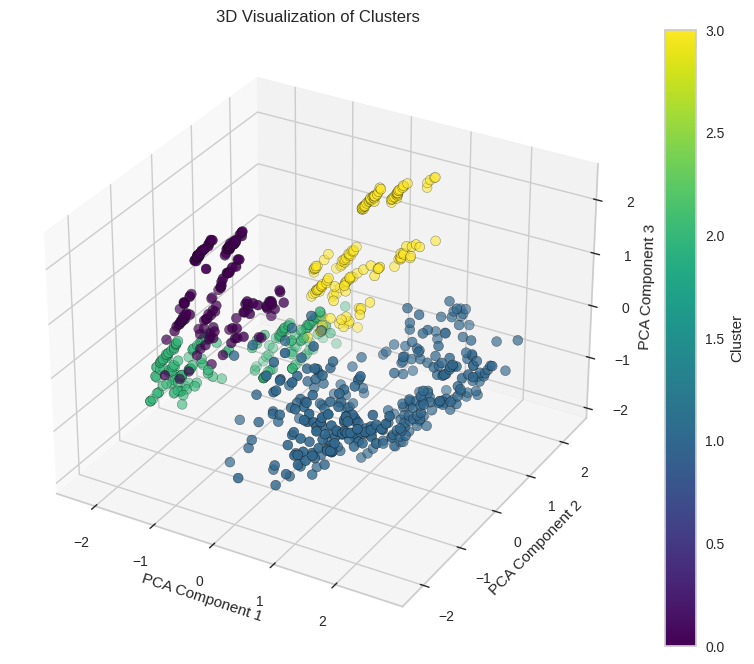

In [43]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final[selected_features])

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=fgmmlabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Giả sử bạn đã có dữ liệu X_continuous (biến liên tục) và X_categorical (biến nhị phân)
# X_continuous và X_categorical là DataFrame pandas

# Phân cụm với GMM cho các biến liên tục
gmm = GaussianMixture(n_components=4, random_state=42)  # Giả sử số cụm là 3
gmm.fit(X_continuous)

# Tính toán log-likelihood ban đầu
log_likelihood_initial = gmm.score(X_continuous)
print(f"Log-likelihood for continuous variables: {log_likelihood_initial}")

# Biến nhị phân
binary_columns = X_categorical.columns.tolist()
log_likelihoods = [log_likelihood_initial]  # Lưu log-likelihood ban đầu
X_with_selected_binary = X_continuous.copy()  # Bắt đầu với các biến liên tục

# Khởi tạo các tham số theo mô phỏng forward selection
best_log_likelihood = log_likelihood_initial  # Log-likelihood ban đầu
selected_features = X_continuous.copy()

while binary_columns:
    best_feature = None
    for col in binary_columns:
        print(f"Đang thử thêm biến nhị phân: {col}")

        # Thêm biến nhị phân hiện tại vào tập dữ liệu
        current_features = selected_features.copy()
        current_features[col] = X_categorical[col]

        # Áp dụng GMM trên dữ liệu với các biến đã chọn
        gmm.fit(current_features)
        log_likelihood_new = gmm.score(current_features)

        print(f"Log-likelihood sau khi thêm '{col}': {log_likelihood_new}")

        # Kiểm tra nếu log-likelihood tăng
        if log_likelihood_new > best_log_likelihood:
            best_log_likelihood = log_likelihood_new
            best_feature = col

    # Nếu có biến nhị phân cải thiện log-likelihood, thêm vào tập đã chọn
    if best_feature is not None:
        print(f"Thêm biến '{best_feature}' giúp cải thiện log-likelihood.")
        selected_features[best_feature] = X_categorical[best_feature]
        binary_columns.remove(best_feature)  # Loại bỏ biến đã thêm khỏi danh sách
    else:
        print("Không có biến nào cải thiện log-likelihood, dừng lại.")
        break

# # Đánh giá mô hình cuối cùng
# aic = gmm.aic(selected_features)
# bic = gmm.bic(selected_features)

# # In kết quả
print(f"Selected Features: {selected_features.columns}")
# print(f"Best Log-likelihood: {best_log_likelihood}")
# print(f"AIC: {aic}")
# print(f"BIC: {bic}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Log-likelihood for continuous variables: 0.8599548741314591
Đang thử thêm biến nhị phân: revenue_Low_Year_Medium_Followers_Low
Log-likelihood sau khi thêm 'revenue_Low_Year_Medium_Followers_Low': 5.943929785513051
Đang thử thêm biến nhị phân: revenue_Low_Rating_Medium_Followers_Low
Log-likelihood sau khi thêm 'revenue_Low_Rating_Medium_Followers_Low': 5.524204236754232
Đang thử thêm biến nhị phân: Chat_Resopnse_High
Log-likelihood sau khi thêm 'Chat_Resopnse_High': 6.0335273572631465
Đang thử thêm biến nhị phân: revenue_Low_Year_High_Followers_Low_Chat_Low
Log-likelihood sau khi thêm 'revenue_Low_Year_High_Followers_Low_Chat_Low': 6.347241188164337
Đang thử thêm biến nhị phân: Positive_High_revenue_Low_Chat_Low
Log-likelihood sau khi thêm 'Positive_High_revenue_Low_Chat_Low': 6.520327081676271
Đang thử thêm biến nhị phân: Rating_High_Year_Medium
Log-likelihood sau khi thêm 'Rating_High_Year_Medium': 5.703953201121662
Đang thử thêm biến nhị phân: revenue_Low_Year_Medium_Chat_Low
Log-lik